SGDRegressor()

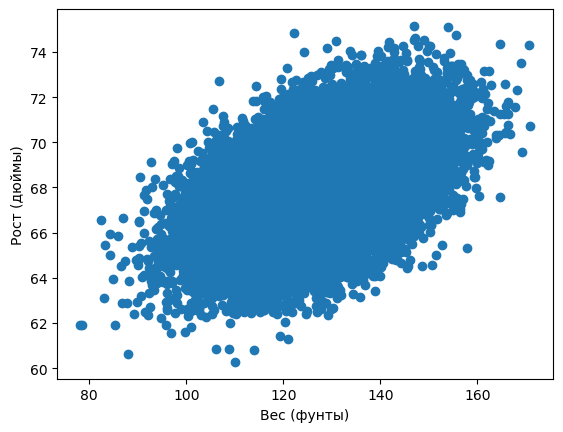

In [34]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator
from sklearn.metrics import log_loss,mean_squared_error,roc_auc_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LinearRegression
data_demo = pd.read_csv('weights_heights.csv')
plt.scatter(data_demo['Weight'],data_demo['Height'])
plt.xlabel("Вес (фунты)")
plt.ylabel("Рост (дюймы)")
X, y = data_demo['Weight'].values, data_demo['Height'].values
X_train, X_valid, y_train, y_valid = train_test_split(X,y, test_size=0.3, random_state=17)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape([X_train.shape[0], 1]))
X_valid_scaled = scaler.transform(X_valid.reshape([X_valid.shape[0], 1]))

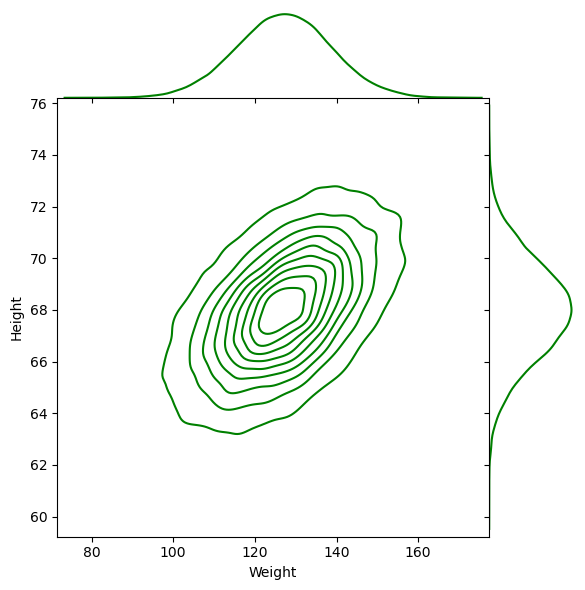

In [7]:
sns.jointplot(x='Weight', y='Height', data=data_demo, kind="kde", space=0, color="g");

In [35]:
y_pred = clf.predict(X_valid_scaled)
mse = mean_squared_error(y_valid,y_pred)
print(mse)

2.671069374312152


In [24]:
print(clf.coef_)

[0.92290435]


In [25]:
print(clf.intercept_)

[67.97245226]


In [26]:
print(np.min(mse))

2.6724040749554536


In [36]:
lr = LinearRegression()
lr.fit(X_train_scaled,y_train)
y_pred = lr.predict(X_valid_scaled)
print(mean_squared_error(y_valid,y_pred))

2.670830767667635


In [46]:
#Реализованный класс
class SGDRegressor(BaseEstimator):
    def __init__(self, eta=1e-3, n_iter=10):
        self.eta = eta
        self.n_iter = n_iter
        self.mse_ = []
        self.weights_ = []
        
    def fit(self, X, y):
        X = np.hstack([np.ones([X.shape[0], 1]), X])
        
        w = np.zeros(X.shape[1])
        
        for it in tqdm(range(self.n_iter)):
            for i in range(X.shape[0]):
                 
                w[0] += 2. * self.eta * (y[i] - w.dot(X[i, :]))
                for j in range(1, X.shape[1]):
                    w[j] += 2. * self.eta * (y[i] - w.dot(X[i, :])) * X[i, j]
                self.weights_.append(w.copy())
                self.mse_.append(mean_squared_error(y, X.dot(w)))
                
        self.w_ = self.weights_[np.argmin(self.mse_)]
                
        return self
                  
    def predict(self, X):
        X = np.hstack([np.ones([X.shape[0], 1]), X])
        
        return X.dot(self.w_)

In [51]:
clf = SGDRegressor()
clf.fit(X_train_scaled,y_train)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:53<00:00,  5.32s/it]


SGDRegressor()

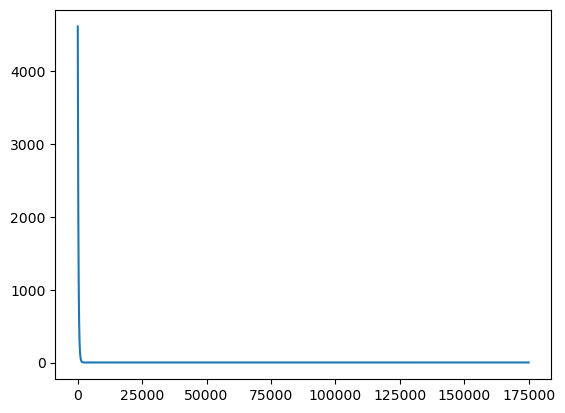

In [49]:
print(plt.plot(range(len(clf.mse_)), clf.mse_))

In [47]:
np.min(clf.mse_), clf.w_

(2.715134470158027, array([67.98947873,  0.94482721]))

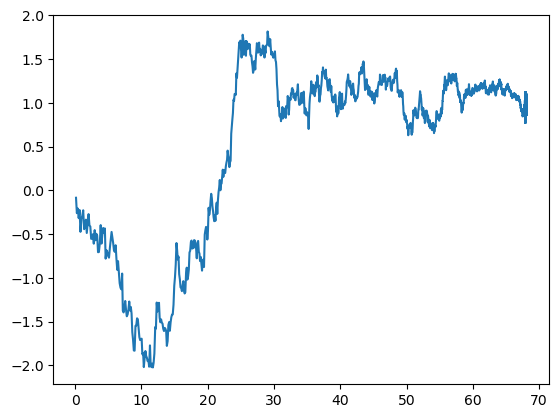

In [50]:
plt.plot([w[0] for w in clf.weights_],[w[1] for w in clf.weights_]);

In [52]:
def sigma(z):
    z = z.flatten()
    z[z > 100] = 100
    z[z < -100] = -100
    return 1. / (1 + np.exp(-z))

In [53]:
#SGDClassifier
class SGDClassifier(BaseEstimator):
    def __init__(self, C=1, eta=1e-3, n_iter=10):
        self.eta = eta
        self.C = C
        self.n_iter = n_iter
        self.loss_ = []
        self.weights_ = []
        
    def fit(self, X, y):
        X = np.hstack([np.ones([X.shape[0], 1]), X])
        best_loss = np.inf
        w = np.ones(X.shape[1])
        
        for it in tqdm(range(self.n_iter)):
            for i in range(X.shape[0]):
                w[0] += self.eta * y[i] * sigma(- y[i] * w.dot(X[i, :]))
                for j in range(1, X.shape[1]):
                    w[j] += self.eta *( self.C * y[i] * X[i, j] * 
                                       sigma(-y[i] * w.dot(X[i, :]))
                                     - w[j])
                
                self.loss_.append(log_loss(y, sigma(X.dot(w))))
                self.weights_.append(w)
    
        self.w_ = self.weights_[np.argmin(self.loss_)]
        return self
                  
    def predict_proba(self, X):
        X = np.hstack([np.ones([X.shape[0], 1]), X])
        p_vec = sigma(X.dot(self.w_)).reshape([X.shape[0], 1])
        return np.hstack([1 - p_vec, p_vec])
    
    def predict(self, X):
        pred_probs = self.predict_proba(X)[:, 1]
        signs = np.sign(pred_probs - 0.5) 
        # но могли остаться нули, если значения в pred_probs = 0.5 в точности
        signs[np.where(signs == 0)] = 1
        return signs

In [54]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
X, y = cancer.data,[-1 if i==0 else 1 for i in cancer.target]


In [56]:
X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size=0.3,random_state=17)

In [61]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
sgd_class = SGDClassifier(C=1,eta=1e-3,n_iter=3)
sgd_class.fit(X_train_scaled,y_train)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.56it/s]


SGDClassifier(n_iter=3)

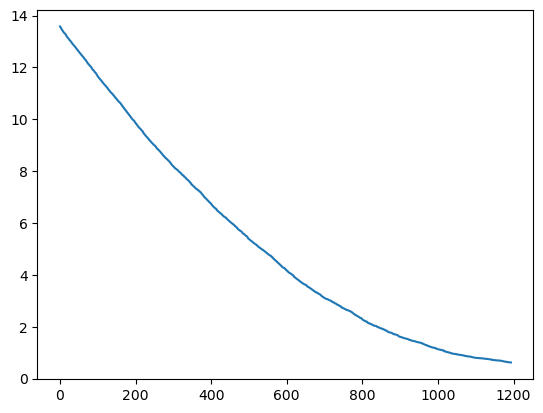

In [63]:
plt.plot(range(len(sgd_class.loss_)),sgd_class.loss_)

In [64]:
sgd_class1 = SGDClassifier(C=1000,n_iter=10,eta=1e-3)
sgd_class1.fit(X_train_scaled,y_train)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.52it/s]


SGDClassifier(C=1000)

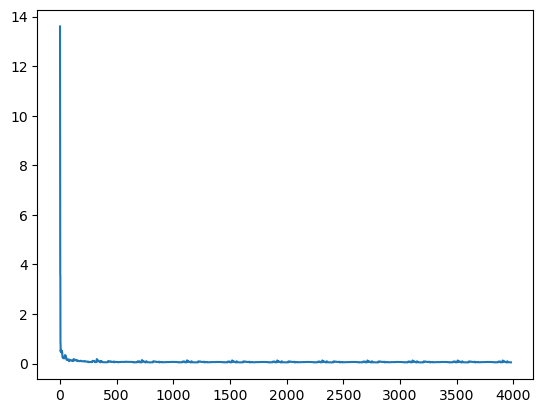

In [65]:
plt.plot(range(len(sgd_class1.loss_)),sgd_class1.loss_)

In [67]:
best_weight = sgd_class1.weights_[np.argmin(sgd_class1.loss_)]
print(best_weight)

[ 0.99407341 -1.12870677 -0.79097561 -0.0967224  -0.07390861 -0.49424025
  1.00318669 -1.35864914 -1.56253297  0.14393583  0.59748894 -1.80614499
 -0.06356839 -0.33032558 -1.00054563  0.25777574  1.56516357 -0.51799109
  0.16821783  0.02365163  0.68150705 -1.02890177 -0.61393469 -0.8654416
 -1.09152451 -1.91813    -0.4449124  -1.56868055 -0.88361326 -0.77832902
 -0.55584325]


In [69]:
print(np.min(best_weight),np.max(best_weight))

-1.9181299999440207 1.5651635728301772


In [72]:
pd.DataFrame({'coef': best_weight,
             'feat': ['intercept'] + list(cancer.feature_names)}).sort_values(by='coef')

,coef,feat
25,-1.918130,worst smoothness
11,-1.806145,radius error
27,-1.568681,worst concavity
8,-1.562533,mean concave points
7,-1.358649,mean concavity
1,-1.128707,mean radius
24,-1.091525,worst area
21,-1.028902,worst radius
14,-1.000546,area error
28,-0.883613,worst concave points


In [74]:
cancer.feature_names[np.argmin(best_weight)-1]

'worst smoothness'

In [75]:
log_loss(y_valid,sgd_class1.predict_proba(X_valid_scaled)[:,1])

0.14271908653850107

In [76]:
roc_auc_score(y_valid,sgd_class1.predict_proba(X_valid_scaled)[:,1])

0.9879284649776454

In [77]:
from sklearn.linear_model import LogisticRegression
lg = LogisticRegression()
lg.fit(X_train_scaled,y_train)


LogisticRegression()

In [79]:
cancer.feature_names[np.argmin(lg.coef_.flatten())]

'radius error'

In [81]:
log_loss(y_valid,lg.predict_proba(X_valid_scaled)[:,1])

0.10855223162448308

In [82]:
roc_auc_score(y_valid,lg.predict_proba(X_valid_scaled)[:,1])

0.9885245901639343